# Import Initial Libraries & Establish S3 Session

In [278]:
!pip install --disable-pip-version-check -q fast_ml

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [279]:
import boto3
import sagemaker
import pandas as pd
import io
import functools
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, MinMaxScaler
from fast_ml.model_development import train_valid_test_split


sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")
s3 = boto3.client("s3")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

# Downlaod Key Data from S3 & Save to Local Sagemaker Instance

In [280]:
def download_s3_files(filename):
    obj = s3.get_object(Bucket=bucket, Key=filename)
    pd.read_csv(io.BytesIO(obj['Body'].read())).to_csv(filename)
    
    print("Successfully downloaded file: {}".format(filename))
    
files = ['college_statistics.csv',
         'combine_data.csv',
         'nfl_draft_profiles.csv',
         'draft_picks.csv',
         'nfl_draft_prospects.csv']

for file in files:
    download_s3_files(file)

Successfully downloaded file: college_statistics.csv
Successfully downloaded file: combine_data.csv
Successfully downloaded file: nfl_draft_profiles.csv
Successfully downloaded file: draft_picks.csv
Successfully downloaded file: nfl_draft_prospects.csv


# Read Data into Dataframes

In [281]:
def read_csv(filename):
    df = pd.read_csv(filename)
    print("Successfuly read {} records into df".format(len(df)))
    
    return df

# Data Quality Checks

## College Statistics

Initially, certain columns have been immmediately dropped or pivoted, based on domain knowledge, usefulness to the problem at hand and ease of analysis.

Further, it can be seen that there are many NaN's in this dataset. However, these NaN's occur in areas where they are expected; certain players are not expected to have any stats for certain metrics. For example, defensive players are not expected to have offensive stats and vice-versa.

Hence, all NaN's in this case will be filled with 0.0.

A data type check was also performed to sense-check that each field is formatted appropriately.

In [282]:
college_stats = read_csv('college_statistics.csv').pivot_table(index=['player_id','player_name','alt_player_id','pos_abbr','school', 'school_abbr', 'season','all_star'],columns='statistic', values='value')\
                                                  .reset_index()

Successfuly read 66672 records into df


In [283]:
print(college_stats.isna().sum())
print(college_stats.dtypes)

college_stats.fillna(0.0, inplace=True)

statistic
player_id                         0
player_name                       0
alt_player_id                     0
pos_abbr                          0
school                            0
                               ... 
Total Touchdowns               2186
Total Two Point Conversions    2186
Yards Per Pass Attempt         3323
Yards Per Reception            2443
Yards Per Rush Attempt         2745
Length: 66, dtype: int64
statistic
player_id                        int64
player_name                     object
alt_player_id                    int64
pos_abbr                        object
school                          object
                                ...   
Total Touchdowns               float64
Total Two Point Conversions    float64
Yards Per Pass Attempt         float64
Yards Per Reception            float64
Yards Per Rush Attempt         float64
Length: 66, dtype: object


## Combine Data

The Round & Pick columns were immediately removed from this dataset, as there is another dataset dedicated to that information; and all datasets will be combined in the next phase of exploration.

For the remainging columns, NaN's were found across key metrics. On a cost-benefit analysis of dropping NaN's (to preserve data integrity as physical fitness information is critical to draft strategies) vs. replacing Nan's with 0's; the latter option was chosen to ensure enough data was present for a model to successfully learn and avoid overfitting. Dropping NaN's enitrely would reduce the dataset to an unnaceptable level, which is indeed a data quality issue.  0 is chosen because players can opt not to participate in certain drills.  Using a median or mean metric to replace NaN's can produce invalid predictions.

In [284]:
combine = read_csv('combine_data.csv').drop(columns=['Unnamed: 0'])

Successfuly read 6218 records into df


In [285]:
print(combine.isna().sum())
print(combine.dtypes)

combine.fillna(0, inplace=True)

Player          0
Pos             0
Ht              0
Wt              0
Forty         172
Vertical     1422
BenchReps    2006
BroadJump    1464
Cone         2225
Shuttle      2155
Year            0
Pfr_ID       1323
AV              0
Team         2480
Round        2480
Pick         2480
dtype: int64
Player        object
Pos           object
Ht             int64
Wt             int64
Forty        float64
Vertical     float64
BenchReps    float64
BroadJump    float64
Cone         float64
Shuttle      float64
Year           int64
Pfr_ID        object
AV           float64
Team          object
Round        float64
Pick         float64
dtype: object


## Draft Picks

Unfortunately in this dataset, the player_id field contained many NaN's and was hence dropped. Instead, the player name (pfr_name) will be used to join data sets.

In [286]:
picks = read_csv('draft_picks.csv').drop(columns=['Unnamed: 0'])

Successfuly read 11632 records into df


In [287]:
print(picks.isna().sum())
print(picks.dtypes)

picks.drop(columns='player_id', inplace=True)

season           0
team             0
round            0
pick             0
pfr_id        1755
pfr_name         0
player_id    11395
side             0
category         0
position         0
dtype: int64
season        int64
team         object
round         int64
pick          int64
pfr_id       object
pfr_name     object
player_id    object
side         object
category     object
position     object
dtype: object


## Draft Prospects

This dataset had many NaN's. The key data in this set, that cannot be found in the other datasets above, were player position ranks and overall ranks, which would be crucial to draft order. 

As such, all other columns were dropped (apart from player identifiers), and NaN's were removed as the rank information cannot be imputed. 

In [288]:
prospects = read_csv('nfl_draft_prospects.csv')

Successfuly read 13354 records into df


In [289]:
print(prospects.isna().sum())
print(prospects.dtypes)

Unnamed: 0            0
draft_year            0
player_id             0
player_name           0
position            309
pos_abbr            309
school              209
school_name         227
school_abbr         396
link                  0
pick               1566
overall            1566
round              1566
traded             1566
trade_note         8848
team               1566
team_abbr          1566
team_logo_espn     1600
guid               7182
weight             7242
height             7273
pos_rk             7365
ovr_rk             8134
grade              7359
player_image      11823
dtype: int64
Unnamed: 0          int64
draft_year          int64
player_id           int64
player_name        object
position           object
pos_abbr           object
school             object
school_name        object
school_abbr        object
link               object
pick              float64
overall           float64
round             float64
traded             object
trade_note         obje

# Exploratory Data Analysis

## College Statistics

We perform quick EDA to get a feel for the data distributions, features we are working with, just to get an idea of how this data can benefit our project

In [290]:
college_stats.describe()

statistic      player_id  alt_player_id       season  Assist Tackles  \
count        3624.000000   3.624000e+03  3624.000000     3624.000000   
mean       100543.730960   3.847922e+06  2017.200607        9.809327   
std         14482.151791   4.195900e+05     1.517690       13.341449   
min           368.000000   2.985844e+06  2014.000000        0.000000   
25%        103548.750000   3.728263e+06  2016.000000        0.000000   
50%        104097.000000   3.957672e+06  2017.000000        3.000000   
75%        104737.250000   4.048231e+06  2018.000000       16.000000   
max        105468.000000   4.579254e+06  2020.000000       96.000000   

statistic  Completion Percentage  Completions  Extra Points Made  \
count                3624.000000  3624.000000        3624.000000   
mean                    4.681098     7.633554           0.417494   
std                    18.153404    42.477853           4.438662   
min                     0.000000     0.000000           0.000000   
25%                     0.000000     0.000000           0.000000   
50%                     0.000000     0.000000           0.000000   
75%                     0.000000     0.000000           0.000000   
max                   100.000000   493.000000          85.000000   

statistic  FGM 1-19 yards  FGM 20-29 yards  FGM 30-39 yards  ...  \
count         3624.000000      3624.000000      3624.000000  ...   
mean             0.001932         0.045530         0.043046  ...   
std              0.049804         0.530985         0.507543  ...   
min              0.000000         0.000000         0.000000  ...   
25%              0.000000         0.000000         0.000000  ...   
50%              0.000000         0.000000         0.000000  ...   
75%              0.000000         0.000000         0.000000  ...   
max              2.000000        12.000000        11.000000  ...   

statistic  Solo Tackles  Total Kicking Points  Total Points  Total Sacks  \
count       3624.000000           3624.000000   3624.000000  3624.000000   
mean          14.735099              0.853753     12.958885     0.680464   
std           18.035017              8.976746     25.115141     3.835349   
min            0.000000              0.000000      0.000000     0.000000   
25%            0.000000              0.000000      0.000000     0.000000   
50%            6.000000              0.000000      0.000000     0.000000   
75%           25.000000              0.000000     12.000000     0.000000   
max          109.000000            134.000000    198.000000    46.000000   

statistic  Total Tackles  Total Touchdowns  Total Two Point Conversions  \
count        3624.000000       3624.000000                  3624.000000   
mean           24.544426          2.018902                     0.024834   
std            30.055744          3.981081                     0.165941   
min             0.000000          0.000000                     0.000000   
25%             1.000000          0.000000                     0.000000   
50%            10.000000          0.000000                     0.000000   
75%            42.000000          2.000000                     0.000000   
max           181.000000         33.000000                     3.000000   

statistic  Yards Per Pass Attempt  Yards Per Reception  Yards Per Rush Attempt  
count                 3624.000000          3624.000000             3624.000000  
mean                     0.727649             3.968543                1.203974  
std                      3.603123             6.511709                3.060852  
min                     -9.000000           -12.000000              -13.000000  
25%                      0.000000             0.000000                0.000000  
50%                      0.000000             0.000000                0.000000  
75%                      0.000000             8.400000                0.000000  
max                     59.000000            58.000000               37.500000  

[8 rows x 61 columns]

Looking at the descriptive statistics, we are quickly alarmed by the season column.  The data only contains information for players from year 2014 to 2020.  This means we have so many years of data missing.  Due to time constraints, we are unable to gather the missing information.  Since we are not able to apply this data to all of the players in consideration, we must withdraw this data source.

## Combine Data

We now consider the combine data for EDA.

In [291]:
combine.describe()

Ht           Wt        Forty     Vertical    BenchReps  \
count  6218.000000  6218.000000  6218.000000  6218.000000  6218.000000   
mean     73.798971   243.372145     4.651457    25.313284    14.175137   
std       2.621373    45.103814     0.840625    14.272668    11.108602   
min      65.000000   149.000000     0.000000     0.000000     0.000000   
25%      72.000000   206.000000     4.530000    24.500000     0.000000   
50%      74.000000   233.000000     4.690000    31.500000    17.000000   
75%      76.000000   281.000000     4.970000    35.000000    23.000000   
max      82.000000   375.000000     6.050000    46.000000    49.000000   

         BroadJump         Cone      Shuttle         Year           AV  \
count  6218.000000  6218.000000  6218.000000  6218.000000  6218.000000   
mean     87.116275     4.676463     2.868932  2009.041975     5.085719   
std      49.029161     3.507552     2.100832     5.471056     7.546556   
min       0.000000     0.000000     0.000000  2000.000000    -4.000000   
25%      93.000000     0.000000     0.000000  2004.000000     0.000000   
50%     111.000000     6.940000     4.180000  2009.000000     1.000000   
75%     119.000000     7.320000     4.430000  2014.000000     8.000000   
max     147.000000     9.120000     5.560000  2018.000000    51.000000   

             Round         Pick  
count  6218.000000  6218.000000  
mean      2.307655    68.368768  
std       2.413651    78.090913  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       2.000000    36.000000  
75%       4.000000   127.750000  
max       7.000000   260.000000

We now observe a boxplot of each of the numeric features within Combine.

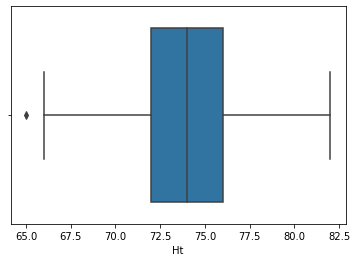

In [292]:
import seaborn as sns

sns.boxplot(x=combine['Ht'])

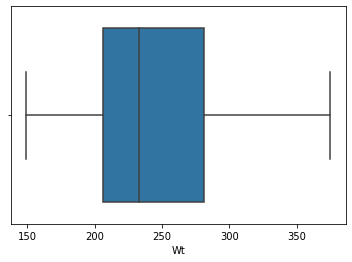

In [293]:
sns.boxplot(x=combine['Wt'])

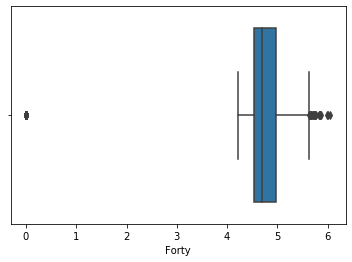

In [294]:
sns.boxplot(x=combine['Forty'])

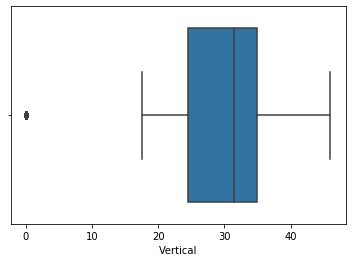

In [295]:
sns.boxplot(x=combine['Vertical'])

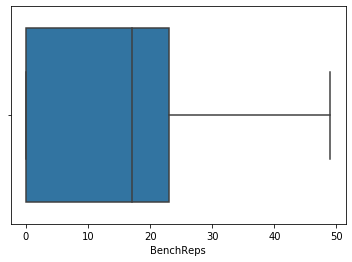

In [296]:
sns.boxplot(x=combine['BenchReps'])

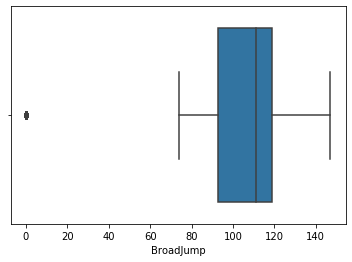

In [297]:
sns.boxplot(x=combine['BroadJump'])

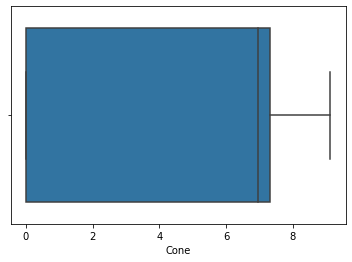

In [298]:
sns.boxplot(x=combine['Cone'])

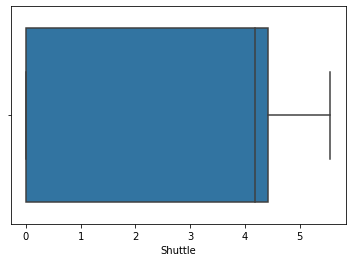

In [299]:
sns.boxplot(x=combine['Shuttle'])

It should be obvious from the scope of this project that the important features are all physical to the player: Height, Weight, Forty Time, Vertical, Bench Reps, Broad Jump, Cone, and Shuttle.  Some players do elect not to participate in a given drill.

## Draft Picks

In [300]:
picks.describe()

season         round          pick
count  11632.000000  11632.000000  11632.000000
mean    1999.270117      5.065853    141.761778
std       12.378608      2.869793     84.830973
min     1980.000000      1.000000      1.000000
25%     1988.000000      3.000000     70.000000
50%     1999.000000      5.000000    139.000000
75%     2010.000000      7.000000    208.000000
max     2021.000000     12.000000    336.000000

The draft picks data is metadata for our players.  It includes information about what pick the player was drafted and what year.  We found while looking at other data that a lot of information we plan to use only started to be recorded in 2004.  So, we will limit our analysis to 2004 data and up.

## Draft Prospects

In [301]:
prospects.describe()

Unnamed: 0    draft_year      player_id          pick       overall  \
count  13354.000000  13354.000000   13354.000000  11788.000000  11788.000000   
mean    6676.500000   1998.189831   29884.278718     16.905921    113.918392   
std     3855.112082     16.116808   28600.931243     10.123831     67.882416   
min        0.000000   1967.000000       1.000000      1.000000      1.000000   
25%     3338.250000   1984.000000   13684.250000      8.000000     56.000000   
50%     6676.500000   2001.000000   20725.500000     16.000000    112.000000   
75%    10014.750000   2012.000000   28963.750000     24.000000    167.000000   
max    13353.000000   2021.000000  105496.000000     54.000000    262.000000   

              round       weight       height       pos_rk       ovr_rk  \
count  11788.000000  6112.000000  6081.000000  5989.000000  5220.000000   
mean       4.110875   244.736093    73.941169    15.862581   156.325670   
std        2.004959    86.888394     2.684655    14.069466    96.825064   
min        1.000000   155.000000    38.000000     1.000000     1.000000   
25%        2.000000   205.000000    72.000000     6.000000    73.000000   
50%        4.000000   234.000000    74.000000    13.000000   148.000000   
75%        6.000000   285.000000    76.000000    22.000000   235.000000   
max        7.000000  6022.000000    81.625000   151.000000   373.000000   

             grade  
count  5995.000000  
mean     57.787490  
std      20.367434  
min      20.000000  
25%      39.000000  
50%      57.000000  
75%      74.000000  
max      99.000000

There aren't any useful visualizations for this data.  We are interested in pos_rk, ovr_rk, and grade, but these are subjective values assigned by domain experts.  Obviously, we expect to see higher picks where the grade is high.

## Combine Datasets for Data Cleansing and Model Training

The code below will join the datasets into one final dataframe for feature analysis/selection and model training. 

Initially, the following columns have been dropped based on their usefulness to the overall goal (determined by domain-knowledge). A conservative approach has been taken to only remove fields that create noise, whilst leaving as many potentially useful fields as possible for further analysis. 

Many fields were also dropped as they were duplicated across datasets (e.g. draft pick and round features in multiple datasets, the duplicated were dropped). 

In [302]:
df = pd.merge(combine, picks, left_on = ['Pfr_ID', 'Year'], right_on = ['pfr_id', 'season'])
df2 = pd.merge(df, prospects, left_on = ['Player', 'Year'], right_on = ['player_name', 'draft_year'])
print(df2.columns)

Index(['Player', 'Pos', 'Ht', 'Wt', 'Forty', 'Vertical', 'BenchReps',
       'BroadJump', 'Cone', 'Shuttle', 'Year', 'Pfr_ID', 'AV', 'Team', 'Round',
       'Pick', 'season', 'team_x', 'round_x', 'pick_x', 'pfr_id', 'pfr_name',
       'side', 'category', 'position_x', 'Unnamed: 0', 'draft_year',
       'player_id', 'player_name', 'position_y', 'pos_abbr', 'school',
       'school_name', 'school_abbr', 'link', 'pick_y', 'overall', 'round_y',
       'traded', 'trade_note', 'team_y', 'team_abbr', 'team_logo_espn', 'guid',
       'weight', 'height', 'pos_rk', 'ovr_rk', 'grade', 'player_image'],
      dtype='object')


In [303]:
df2.drop(columns=['Player','Pfr_ID','Team','season','team_x','round_x','pick_x', 'pfr_id', 'pfr_name','position_x','Round', 'Unnamed: 0', 'draft_year',
       'player_id', 'player_name', 'position_y', 'pos_abbr','school',
       'school_name','link', 'pick_y', 'overall', 'round_y','category',
       'traded', 'trade_note', 'team_y', 'team_abbr', 'team_logo_espn', 'guid','player_image'], inplace=True)

df2.dropna(inplace=True)

In [304]:
df2

Index(['Pos', 'Ht', 'Wt', 'Forty', 'Vertical', 'BenchReps', 'BroadJump',
       'Cone', 'Shuttle', 'Year', 'AV', 'Pick', 'side', 'school_abbr',
       'weight', 'height', 'pos_rk', 'ovr_rk', 'grade'],
      dtype='object')

In [ ]:
## Feature Creation: Encoding and Scaling

## Feature Transformation: Encoding and Scaling

As can be seen in the dataset that remains, there are many categorical fields remaining:
    
    - Pos: the position label of the player, crucial to their draft order and competition.
    - side: Denotes whether a player is a defensive or offensive player, again vital to their draft prospects.
    - school_abbr: This field will be retained to examine whether the school a player comes from has a significant impact on their draft prospects (particularly those that go to highly competitive schools). 

In [305]:
label_encoder = LabelEncoder()
df2['Pos'] = label_encoder.fit_transform(df2['Pos'])
df2['side'] = label_encoder.fit_transform(df2['side'])
df2['school_abbr'] = label_encoder.fit_transform(df2['school_abbr'])

Finally, all fields except for Pick (the target variable) have been scaled to feed into a model. 

In [306]:
# scaler = MinMaxScaler()
df2.loc[:,~df2.columns.isin(['Pick'])] = scaler.fit_transform(df2.loc[:,~df2.columns.isin(['Pick'])])

df2

Pos        Ht        Wt     Forty  Vertical  BenchReps  BroadJump  \
718   0.173913  0.600000  0.709360  0.856410  0.000000   0.000000   0.000000   
719   0.956522  0.800000  0.522167  0.835897  0.666667   0.346939   0.721088   
720   0.695652  0.800000  0.881773  0.866667  0.677778   0.693878   0.721088   
721   0.695652  0.666667  1.000000  0.938462  0.555556   0.551020   0.666667   
722   0.173913  0.733333  0.714286  0.888889  0.600000   0.408163   0.687075   
...        ...       ...       ...       ...       ...        ...        ...   
3552  1.000000  0.600000  0.256158  0.774359  0.744444   0.000000   0.768707   
3553  0.782609  0.466667  0.246305  0.818803  0.700000   0.000000   0.700680   
3554  0.347826  0.600000  0.738916  0.000000  0.000000   0.000000   0.000000   
3555  0.043478  0.466667  0.133005  0.772650  0.000000   0.163265   0.816327   
3556  0.217391  0.666667  0.467980  0.817094  0.733333   0.510204   0.775510   

          Cone   Shuttle  Year        AV   Pick  side  school_abbr    weight  \
718   0.000000  0.000000   0.0  0.200000   74.0   0.0     0.608040  0.716418   
719   0.918224  0.827138   0.0  0.163636  245.0   0.5     0.708543  0.527363   
720   0.945093  0.888476   0.0  0.145455  123.0   0.5     0.457286  0.870647   
721   0.963785  0.901487   0.0  0.527273   16.0   0.5     0.030151  0.905473   
722   0.882009  0.821561   0.0  0.072727  114.0   0.0     0.492462  0.686567   
...        ...       ...   ...       ...    ...   ...          ...       ...   
3552  0.817757  0.000000   1.0  0.072727    0.0   0.5     0.819095  0.258706   
3553  0.810748  0.771375   1.0  0.072727    0.0   0.5     0.763819  0.248756   
3554  0.000000  0.000000   1.0  0.072727    0.0   0.5     0.819095  0.746269   
3555  0.000000  0.776952   1.0  0.072727    0.0   0.0     0.065327  0.134328   
3556  0.816589  0.817844   1.0  0.072727    0.0   0.0     0.386935  0.472637   

        height  pos_rk    ovr_rk     grade  
718   0.860465    0.22  0.239247  0.617647  
719   0.930233    0.16  0.365591  0.485294  
720   0.930233    0.28  0.513441  0.352941  
721   0.906977    0.02  0.051075  0.911765  
722   0.906977    0.18  0.206989  0.676471  
...        ...     ...       ...       ...  
3552  0.860465    0.62  0.690860  0.161765  
3553  0.813953    0.18  0.561828  0.294118  
3554  0.837209    0.06  0.099462  0.794118  
3555  0.813953    0.28  0.325269  0.544118  
3556  0.883721    0.36  0.572581  0.279412  

[2506 rows x 19 columns]

## Train-Test-Validation Split

In [307]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df, target = 'Pick', train_size=0.9, valid_size=0.05, test_size=0.05)

dfs = [X_train, y_train, X_valid, y_valid, X_test, y_test]
labels = ['X_train', 'y_train', 'X_valid', 'y_valid', 'X_test', 'y_test']

for label, df in zip(labels, dfs):
    print("Length of {} is {} records.".format(label, len(df)))

Length of X_train is 3421 records.
Length of y_train is 3421 records.
Length of X_valid is 190 records.
Length of y_valid is 190 records.
Length of X_test is 191 records.
Length of y_test is 191 records.
